In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.patheffects as pe
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import linear_model
import statsmodels.api as sm
import scipy
from matplotlib.colors import to_rgba

In [2]:
# Read the neon veg structure measurements!
# neon_vst = pd.read_csv("../data/output/NEON_VST_FIRSTMEASUREMENTS.csv")
# 07062023
neon_vst = pd.read_csv("../data/output/NEON_VST_TREES.csv")


In [3]:
print(len(neon_vst))

167752


In [4]:
## Clean data
# Use only live trees
neon_vst_filt = neon_vst[neon_vst['plantStatus'].str.contains("Live", na=False)].reset_index(drop=True)
neon_vst_filt = neon_vst_filt[~neon_vst_filt['plantStatus'].str.contains("damage|broken", na=False)].reset_index(drop=True)
# Get average crown diameter
neon_vst_filt["avgCrownDiameter"] = (neon_vst_filt["maxCrownDiameter"] + neon_vst_filt["ninetyCrownDiameter"])/2
neon_vst_filt['crownRadius'] = neon_vst_filt['avgCrownDiameter']/2
# Get vertical crown diameter
neon_vst_filt["verticalDiameter"] = neon_vst_filt["height"] - neon_vst_filt["baseCrownHeight"]
neon_vst_filt['verticalCrownRadius'] = neon_vst_filt['verticalDiameter']/2
# calculate crown volume 
hrad = neon_vst_filt["avgCrownDiameter"]/2
vrad = neon_vst_filt["verticalDiameter"]/2
# appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * (vrad)
neon_vst_filt['crown_vol'] =(4/3) * np.pi * (hrad**2) * ((1/4)*neon_vst_filt["height"])

In [5]:
neon_vst_filt.shape

(121824, 50)

In [15]:
## Clean data

# These are all the measurements that seem like errors
# But we keep in the distribution plotting so we can view the data

# outlier_trees = ['NEON.PLA.D01.BART.05414', 'NEON.PLA.D01.HARV.05718',
#                'NEON.PLA.D01.HARV.05764', 'NEON.PLA.D03.JERC.00993',
#                'NEON.PLA.D08.TALL.01932', 'NEON.PLA.D05.TREE.00161',
#                'NEON.PLA.D17.SOAP.05687', 'NEON.PLA.D12.YELL.01123']

# Remove data with errors (large DBH, height, etc.)
outlier_trees = ['NEON.PLA.D17.SOAP.05687'] # clear error with ht>160m
neon_vst_filt = neon_vst_filt[~neon_vst_filt['individualID'].isin(outlier_trees)].copy().reset_index(drop=True)

# # filter for only trees
# growthForm_list = ['single bole tree', 'multi-bole tree','small tree'] # 'small tree'
# # growthForm_list = ['small tree']
# neon_vst_filt = neon_vst_filt[neon_vst_filt['growthForm'].isin(growthForm_list)].copy()

# Lets just drop duplicates records for now
# neon_vst_filt = neon_vst_filt.drop_duplicates(subset=['individualID'])

In [16]:
neon_vst_filt.shape

(121823, 50)

In [17]:
###############
## Distribution
###############

In [18]:
# maybe remove D14? Not enough data after filtering for growthForm, etc.
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13', "D14",
                    'D15', 'D16', 'D17', 'D19', 'D20']

In [19]:
import matplotlib.ticker as plticker
loc = plticker.MaxNLocator(5) # this locator puts ticks at regular intervals
## Plotting and output params
outdir = "../figs/veg-struct/distribution"
# Choose structural variable to plot
vars_list = ["stemDiameter", "height","avgCrownDiameter"]
xlabs_list = ["Stem Diameter (cm)", "Height (m)","Avg. Crown Diameter (m)"]

# Filter for selected domains only
df_filt = neon_vst_filt.loc[neon_vst_filt['domainID'].isin(selected_domains)].copy()
for varidx, varname in enumerate(vars_list):
    
    # Get min and max for figure
    xmin = df_filt.groupby("domainID")[varname].min().min()
    xmax = df_filt.groupby("domainID")[varname].max().max()

    # Loop through domains and plot structure
    fig,axs = plt.subplots(6,3, figsize=(8,14),sharex=True)
    ax = axs.flatten()
    plot_idx = 0
    for domain, group in df_filt.groupby("domainID"):
        # Add violin plot
        sns.violinplot(x=group[varname], ax=ax[plot_idx]) # color="#1f77b4"
        # Subplot aesthetics
        ax[plot_idx].set_title(domain,fontsize=18,fontweight="bold")
        ax[plot_idx].set_xlim(0,xmax)
        ax[plot_idx].tick_params(axis="x", labelrotation=45)
        ax[plot_idx].set_xlabel(None)
        ax[plot_idx].xaxis.set_major_locator(loc)
        
        ax[plot_idx].text(0.98, 0.015,
                          f'n={len(group[varname][~group[varname].isna()])}',
                          fontsize = 14,
                          ha='right', va='bottom', transform=ax[plot_idx].transAxes)
        # Increment plot index
        plot_idx+=1
        
    # Figure aesthetics
    fig.text(0.5, 0.005, xlabs_list[varidx], ha='center')
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.06)
    fig.savefig(os.path.join(outdir,f"DOMAINS_{varname}_dist.png"), dpi=300)
    plt.close()

In [20]:
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.3,
              rc={'grid.color': '#ededed'})

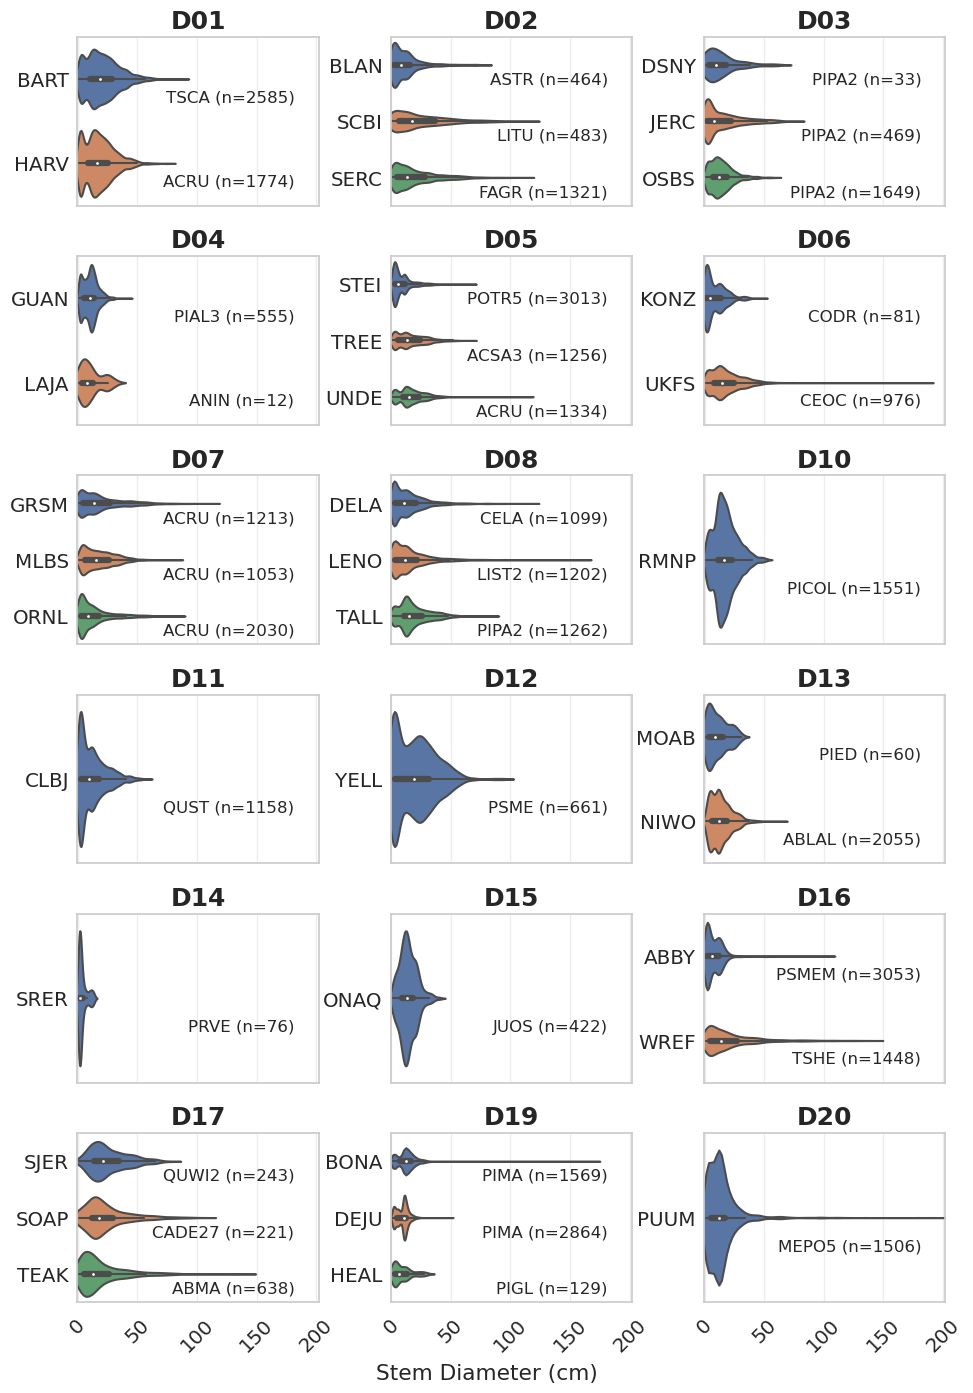

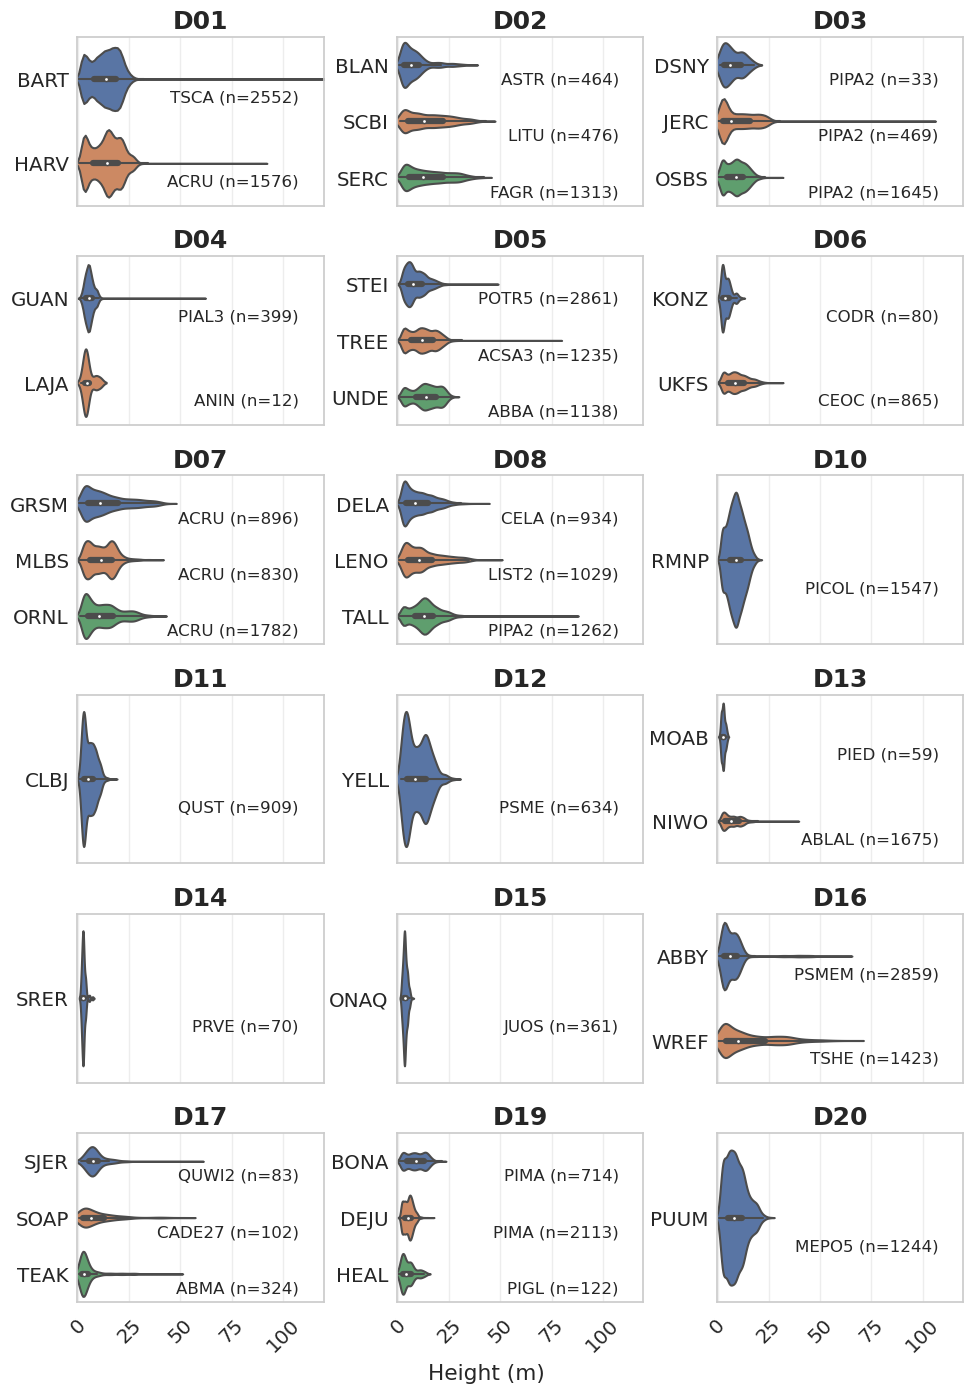

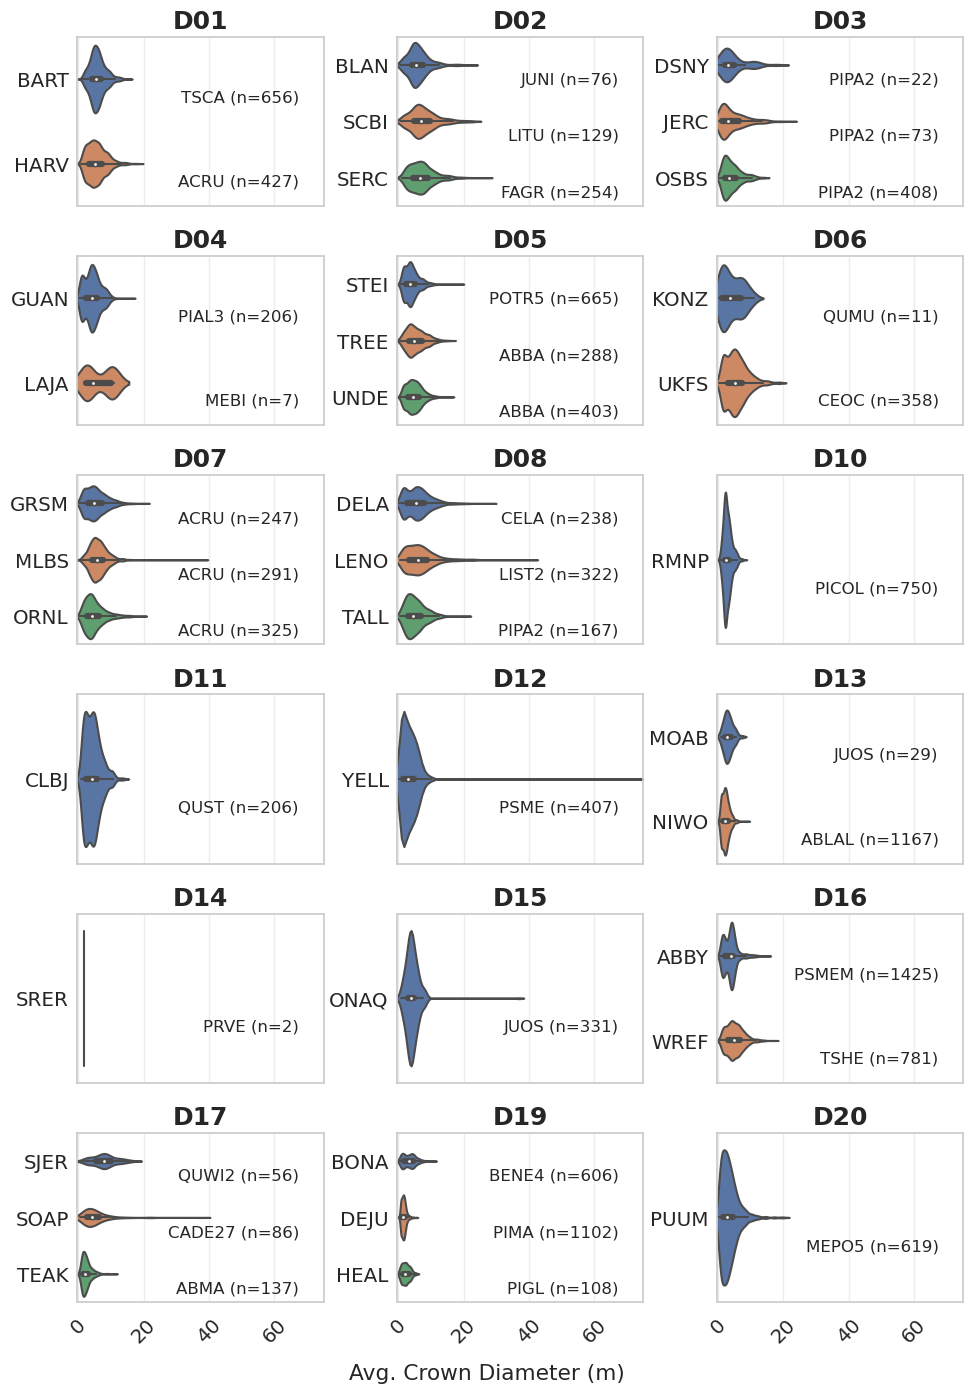

In [21]:
import matplotlib.ticker as plticker
loc = plticker.MaxNLocator(5) # this locator puts ticks at regular intervals
## Plotting and output params
outdir = "../figs/veg-struct/distribution"
# Choose structural variable to plot
vars_list = ["stemDiameter", "height","avgCrownDiameter"]
xlabs_list = ["Stem Diameter (cm)", "Height (m)","Avg. Crown Diameter (m)"]

# Filter for selected domains only
df_filt = neon_vst_filt.loc[neon_vst_filt['domainID'].isin(selected_domains)].copy()
for varidx, varname in enumerate(vars_list):
    
    # Get min and max for figure
    xmin = df_filt.groupby("domainID")[varname].min().min()
    xmax = df_filt.groupby("domainID")[varname].max().max()
    xloc = xmax * 0.9

    # Loop through domains and plot structure
    fig,axs = plt.subplots(6,3, figsize=(10,14),sharex=True)
    ax = axs.flatten()
    plot_idx = 0
    for domain, group in df_filt.groupby("domainID"):
        # Drop na values in group
        group = group.loc[~group[varname].isna()].copy().sort_values(by=['siteID'])
        # Add violin plot
        sns.violinplot(x=group[varname], y=group['siteID'] ,
                       ax=ax[plot_idx]) # color="#1f77b4"
        
        # Modify yaxis tick labels (sitenames) to include
        taxon_arr = group.groupby("siteID")['taxonID'].value_counts()
        sites = taxon_arr.index.get_level_values("siteID").unique()
        species_labels = []
        for s_idx, site in enumerate(sites):
            taxonid = taxon_arr[site].index[0]
            taxon_count = taxon_arr[site][0]
            species_labels.append(taxonid)
            # Add text
            ax[plot_idx].text(xloc, s_idx+0.125,
                              f"{taxonid} (n={taxon_count})",
                              ha='right', va='top', fontsize=12) #, transform=ax1.transAxes (not needed)

        # Subplot aesthetics
        ax[plot_idx].set_title(domain,fontsize=18,fontweight="bold")
        ax[plot_idx].set_xlim(-0.25,xmax)
        ax[plot_idx].tick_params(axis="x", labelrotation=45)
        ax[plot_idx].tick_params(axis="y", pad=0.1)
        ax[plot_idx].set_xlabel(None)
        ax[plot_idx].set_ylabel(None)
        ax[plot_idx].xaxis.set_major_locator(loc)
        # Increment plot index
        plot_idx+=1
        
        
    # Figure aesthetics
    fig.text(0.5, 0.005, xlabs_list[varidx], ha='center')
    fig.tight_layout()
#     ax[-1].remove() # Remove last empty subplot
    fig.subplots_adjust(bottom=0.06,wspace = 0.3)
    fig.savefig(os.path.join(outdir,f"DOMAINS_{varname}_dist_v2.png"), dpi=300)
    plt.show()

In [25]:
#################
## Plot structure by growthForm
#################

In [22]:
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.2,
              rc={'grid.color': '#ededed'})
flierprops = dict(marker='x', markersize=2.25,markerfacecolor='None')

In [27]:
growthForms = ['sapling', 'small tree', 'small shrub', 'single bole tree',
       'multi-bole tree', 'single shrub']
palette_list = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860']
palette_dict = dict(zip(growthForms, palette_list))

In [28]:
# Loop through domains and plot structure
import matplotlib.ticker as plticker
loc = plticker.MaxNLocator(5) # this locator puts ticks at regular intervals

## Plotting and output params
outdir = "../figs/veg-struct/distribution/domain_growthForms"
# Use only live trees
vst_filt = neon_vst[neon_vst['plantStatus'].str.contains("Live", na=False)].reset_index(drop=True)
vst_filt = vst_filt[~vst_filt['plantStatus'].str.contains("damage|broken", na=False)].reset_index(drop=True)
# Get average crown diameter
vst_filt["avgCrownDiameter"] = (vst_filt["maxCrownDiameter"] + vst_filt["ninetyCrownDiameter"])/2
vst_filt['crownRadius'] = vst_filt['avgCrownDiameter']/2
# Remove data with errors (large DBH, height, etc.)
outlier_trees = ['NEON.PLA.D17.SOAP.05687'] #outlier
vst_filt = vst_filt[~vst_filt['individualID'].isin(outlier_trees)].copy().reset_index(drop=True)
# Lets just drop duplicates records for now
vst_filt = vst_filt.drop_duplicates(subset=['individualID'])

# Filter data
growthForm_list = ['sapling', 'small tree', 'small shrub', 'single bole tree',
       'multi-bole tree', 'single shrub']
vst_filt = vst_filt[vst_filt['growthForm'].isin(growthForm_list)].copy().reset_index(drop=True)
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13', 'D14',
                    'D15', 'D16', 'D17', 'D19', 'D20']
df_filt = vst_filt.loc[vst_filt['domainID'].isin(selected_domains)].copy()

# Choose structural variable to plot
vars_list = ["stemDiameter", "height","avgCrownDiameter"]
xlabs_list = ["Stem Diameter (cm)", "Height (m)","Avg. Crown Diameter (m)"]

for varidx, varname in enumerate(vars_list):

    # Init figure
    fig,axs = plt.subplots(6,3,figsize=(9,15), sharex=True)
    ax = axs.flatten()
    plot_idx=0
    
    # Get min and max for each domain (for figure loc)
    xmin = df_filt.groupby("domainID")[varname].min().min()
    xmax = df_filt.groupby("domainID")[varname].max().max()
    xloc = xmax - 1

    for domain, group in df_filt.groupby("domainID"):

        group = group.sort_values(by=['growthForm'])
        # plot boxplot
        sns.boxplot(x=group[varname],y=group["growthForm"],palette=palette_dict,
                    ax=ax[plot_idx], linewidth=0.6,
                    notch=True,
                    flierprops=flierprops)
        # Get tick labels
        ticklabs = [t.get_text() for t in ax[plot_idx].get_yticklabels()]
        group = group.loc[~group[varname].isna()].copy()
        for i, txt in enumerate(ticklabs):
            # ax[plot_idx].text(group[varname].max()-10,range(0,len(ticklabs)),s=40)
            ax[plot_idx].text(xloc, i, f"{txt} (n={len(group[group['growthForm']==txt])})", ha='right', 
                     va='center', fontsize=11) #, transform=ax1.transAxes (not needed)

        # Add figure aesthetics
        ax[plot_idx].set_title(domain,fontsize=17,fontweight="bold")
#         ax[plot_idx].set_xlim(left=0)
        ax[plot_idx].tick_params(axis="x", labelrotation=0)
        ax[plot_idx].get_yaxis().set_visible(False)
        ax[plot_idx].set_xlabel(None)
        ax[plot_idx].set_ylabel(None)
    #     ax.set_xticks(np.arange(0, xmax+1, 20.0))
        ax[plot_idx].xaxis.set_major_locator(loc)
        # Increment plot index
        plot_idx+=1

    # xlabel = varname
    fig.tight_layout()
    fig.text(0.5, 0.005, xlabs_list[varidx], ha='center')
    # fig.subplots_adjust(bottom=0.06)
    fig.savefig(os.path.join(outdir,f"DOMAINS_growthForm_{varname}_dist.png"), dpi=300)
    plt.close()

In [23]:
###############
## PLOT DOMINANT SPECIES STRUCTURE
###############

In [24]:
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.2,
              rc={'grid.color': '#ededed'})

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=40.0) # this locator puts ticks at regular intervals

In [25]:
# Now, lets plot by domain the 4 most dominant species (6x3 grid necessary)
outdir = "../figs/veg-struct/distribution/domain_dominant_species"

# Plot all variables (stemDiameter, height, maxCrownDiameter, ninetyCrownDiameter)
varnames_list = ["stemDiameter", 'height', 'avgCrownDiameter']
xlabels_list = ["Stem Diameter (cm)", "Height (m)", "Avg. Crown Diameter (m)"]

selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13', "D14",
                    'D15', 'D16', 'D17', 'D19', 'D20']
# Filter for selected domains only
df_filt = neon_vst_filt.loc[neon_vst_filt['domainID'].isin(selected_domains)].copy()

for var_idx, varname in enumerate(varnames_list):
    # Create figure
    fig, axs = plt.subplots(6,3, figsize=(8,12), sharex=True)
    ax = axs.flatten()

    # Loop through domains
    plot_idx = 0
    for domain, group in df_filt.groupby("domainID"):

        # Get top 4 species in domain, then plot their structure
        taxon_ids = group['taxonID'].value_counts()[:4].index

        # Filter for species id
        domain_topspecies_df = group[group['taxonID'].isin(taxon_ids)].copy().sort_values(by=['taxonID'])

        # boxplot distribution
        sns.boxplot(x=domain_topspecies_df[varname],
                    y=domain_topspecies_df["taxonID"],linewidth=0.6,
                    ax=ax[plot_idx], notch=True, fliersize=3,flierprops={"marker": "x"})
        # Get tick labels
        ticklabs = [t.get_text() for t in ax[plot_idx].get_yticklabels()]
        domain_topspecies_df = domain_topspecies_df.loc[~domain_topspecies_df[varname].isna()].copy()
        if varname=="height":
            xloc=50
        elif varname=="stemDiameter":
            xloc=130
        elif varname=="avgCrownDiameter":
            xloc=24
        for i, txt in enumerate(ticklabs):
            n = len(domain_topspecies_df[domain_topspecies_df['taxonID']==txt])
            # ax[plot_idx].text(group[varname].max()-10,range(0,len(ticklabs)),s=40)
            ax[plot_idx].text(xloc, i, f"n={n}", ha='right', 
                     va='center', fontsize=11) #, transform=ax1.transAxes (not needed)
            
        # subplot aesthetics
        ax[plot_idx].set_title(domain,fontsize=16,fontweight="bold")
        ax[plot_idx].set_xlabel(None)
        ax[plot_idx].set_ylabel(None)
        ax[plot_idx].tick_params(axis="y",labelsize=12)
        # Set number of ticks!
        ax[plot_idx].xaxis.set_major_locator(plticker.MaxNLocator(5))

        # increment plot idx
        plot_idx+=1

    # Figure aesthetics
    xlabel = xlabels_list[var_idx]
    fig.text(0.5, 0.005, xlabel, ha='center')
    
    # Figure aesthetics
    fig.tight_layout()
    fig.subplots_adjust(wspace=.33)
#     ax[-1].remove() # Remove last empty plot
    
    # save to output folder
    fig.savefig(os.path.join(outdir, f"DOMAINS-dominant-species-{varname}.png"),dpi=300)
    plt.close()


In [26]:
#########
## Plot dsitrubtion on a per site basis
#########

In [27]:
import matplotlib.patheffects as pe

# output dir
outdir = "../figs/veg-struct/distribution/sites"
# kwargs for plotting
kwargs = {"edgecolor":"black", "linewidth":.25}
## Clean data
# Use only live trees
neon_vst_filt = neon_vst[neon_vst['plantStatus'].str.contains("Live", na=False)].reset_index(drop=True)
neon_vst_filt = neon_vst_filt[~neon_vst_filt['plantStatus'].str.contains("damage|broken", na=False)].reset_index(drop=True)
# Get average crown diameter
neon_vst_filt["avgCrownDiameter"] = (neon_vst_filt["maxCrownDiameter"] + neon_vst_filt["ninetyCrownDiameter"])/2
neon_vst_filt['crownRadius'] = neon_vst_filt['avgCrownDiameter']/2
# Get vertical crown diameter
neon_vst_filt["verticalDiameter"] = neon_vst_filt["height"] - neon_vst_filt["baseCrownHeight"]
neon_vst_filt['verticalCrownRadius'] = neon_vst_filt['verticalDiameter']/2
# calculate crown volume 
hrad = neon_vst_filt["avgCrownDiameter"]/2
vrad = neon_vst_filt["verticalDiameter"]/2
# appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * (vrad)
neon_vst_filt['crown_vol'] =(4/3) * np.pi * (hrad**2) * ((1/4)*neon_vst_filt["height"])

# USE ALL RAW DATA
for site, group in neon_vst_filt.groupby("siteID"):
    
    ## Get sdir for outputs
    sdir = outdir
    ##
    fig = plt.figure(figsize=(12,14))
    gs = fig.add_gridspec(3,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    
    taxon = group['taxonID'].value_counts().index
    taxon_counts = group['taxonID'].value_counts().values
    
    taxcount_other_bool = taxon_counts<=10
    taxcount_other_tot = np.nansum(taxon_counts[taxcount_other_bool])   
#     argsort = taxon.argsort() # Get indices for proper order
#     taxon = taxon[argsort]
#     taxon_counts = taxon_counts[argsort]
    
    taxon = taxon[~taxcount_other_bool]
    taxon_counts = taxon_counts[~taxcount_other_bool]
    taxon=np.append(taxon,['other'])
    taxon_counts=np.append(taxon_counts,[taxcount_other_tot])
    
    # barplot distribution
    sns.barplot(x=taxon, y=taxon_counts,
                ax=ax1,edgecolor="black",linewidth=.7)
    
#     sns.countplot(x="taxonID", data=group, ax=ax1)
    ax1.tick_params(rotation=40,axis="x")
    ax1.set_ylabel("Count")

    # add histograms for structure params
    
    ## Height 
    sns.histplot(data=group, x="stemDiameter",
                 ax=ax2)
    ax2.set_xlim(0,right=50)
    ax2.set_xlabel("Stem Diameter (cm)")
    ## Height
    sns.histplot(data=group, x="height",
                 ax=ax3)
    ax3.set_xlabel("Height (m)")
    ## Height 
    sns.histplot(data=group, x="maxCrownDiameter",
                 ax=ax4)
    ax4.set_xlim(0,right=30)
    ax4.set_xlabel("Max Crown Diameter (m)")
    ## Height 
    sns.histplot(data=group, x="avgCrownDiameter",
                 ax=ax5)
    ax5.set_xlim(0,right=30)    
    ax5.set_xlabel("Average Crown Diameter (m)")

    # add figure aesthetics
    fig.suptitle(site,fontweight="bold",fontsize=22)
    ax1.text(0.985, 0.975,
             f'n={len(group)}', ha='right', va='top',
             transform=ax1.transAxes)
    # fig.subplots_adjust(hspace=.3,wspace=.25)
    fig.tight_layout()
    # save to output folder
    fig.savefig(os.path.join(sdir, f"{site}-veg-struct-dist.png"),dpi=300)
    plt.close()
